# These are the Cartography visuals.

# To Do:
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

In [63]:
import sys
sys.path.append("../notebooks/scripts/")

# Imports Section 

In [64]:
import altair as alt
from altair_saver import save
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
import seaborn as sns

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [65]:
alt.renderers.set_embed_options(
    padding={"left": 0, "right": 0, "bottom": 1, "top": 1}
)

RendererRegistry.enable('default')

In [66]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 120
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
mpl.rc('text', usetex=False)

In [67]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver
    import selenium.webdriver
    
    driver = selenium.webdriver.Chrome()
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# Zika Specific Variables 

In [69]:
colors = snakemake.input.colors
node_df = snakemake.input.node_df

pca_df = snakemake.input.pca_df
explained_variance_pca = snakemake.input.explained_variance_pca

mds_df = snakemake.input.mds_df
tsne_df = snakemake.input.tsne_df
umap_df = snakemake.input.umap_df

#Scatterplot:
scatterplot_pca = snakemake.input.scatterplot_pca
scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

scatterplot_mds = snakemake.input.scatterplot_mds
scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

scatterplot_tsne = snakemake.input.scatterplot_tsne
scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

scatterplot_umap = snakemake.input.scatterplot_umap
scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

NameError: name 'snakemake' is not defined

In [70]:
clades_to_plot = None

# Reading in all the data from the scripts

In [76]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/zika-nextstrain'

In [81]:
node_df = pd.read_csv(node_df, sep="\t")
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)
node_df = node_df.take(node_df["clade_membership"].dropna().index.values.tolist())

In [87]:
colors = pd.read_csv(colors, sep="\t", names=[i for i in range(0,101)])

In [98]:
domain =  node_df["clade_membership"].drop_duplicates().values
range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]

In [99]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

clades_to_plot undefined


In [100]:
node_df['clade_membership'].value_counts()

c4            140
c2            123
c3            110
c5            105
c7             44
c1             43
c6             43
c9             34
c10            29
unassigned      3
Name: clade_membership, dtype: int64

## PCA

In [101]:
principalDf = pd.read_csv(pca_df, index_col=0)

In [102]:
explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df

,explained variance,principal components
0,0.3304,1
1,0.0668,2
2,0.0582,3
3,0.0411,4
4,0.0277,5
5,0.0181,6
6,0.0137,7
7,0.0127,8
8,0.0100,9
9,0.0085,10


NameError: name 'snakemake' is not defined

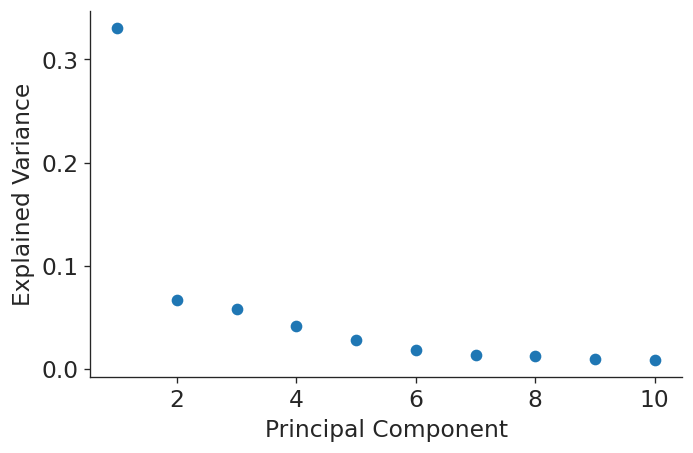

In [103]:
plt.plot(explained_variance_df['principal components'].values.tolist(), explained_variance_df["explained variance"].values.tolist(), 'o')

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.tight_layout()
plt.savefig(snakemake.output.Explained_variance_PCA)

In [ ]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [104]:
merged_pca_df.head()

,strain,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca_label,pca_label_default,date,y,clade_membership,clade_membership_color
0,FrenchPolynesia2014_060114_016,-0.998547,-0.175069,-0.003561,0.361745,1.458287,0.384682,0.105213,-0.495075,-0.058393,0.096919,-1,-1,2014.02,155,c1,c1
1,1_0049_PF,-1.198790,-0.180801,0.006346,0.362463,1.145100,0.554967,0.122504,-0.539326,-0.060135,0.060048,7,7,2014.00,159,c1,c1
2,1_0030_PF,-0.799810,-0.187487,-0.026014,0.402228,1.683231,0.217245,0.093380,-0.469679,-0.057281,0.115447,-1,-1,2013.84,128,c1,c1
3,1_0035_PF,-0.796745,-0.175749,-0.004483,0.412166,1.666182,0.218447,-0.005780,-0.474135,-0.050990,0.123062,-1,-1,2014.09,130,c1,c1
4,1_0087_PF,-0.796488,-0.175817,-0.005464,0.405828,1.662626,0.223019,0.092407,-0.445756,-0.051656,0.118796,-1,-1,2013.92,131,c1,c1


In [105]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [106]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"], domain, range_)
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [107]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

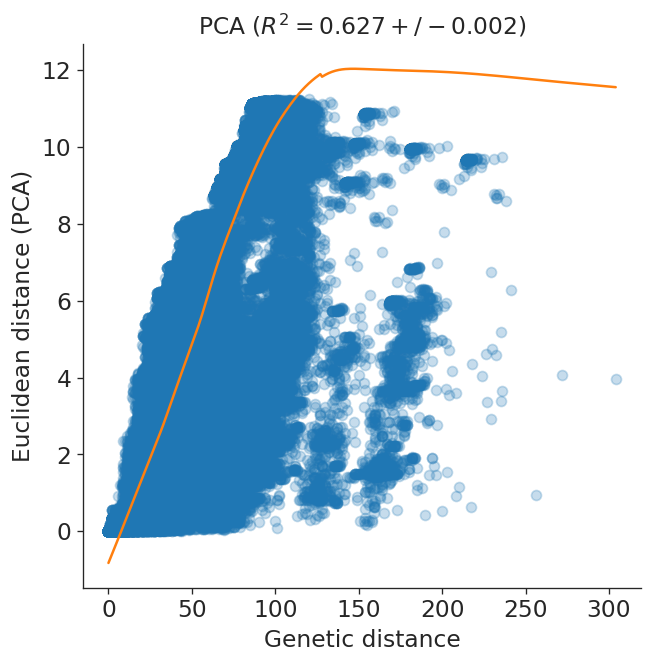

In [108]:
total_df_PCA = pd.read_csv(scatterplot_pca,index_col=0)
metadata_PCA = pd.read_csv(scatterplot_pca_metadata, index_col=0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title(f"PCA ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

## MDS

In [109]:
MDS_df = pd.read_csv(mds_df,index_col=0)

In [110]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [111]:
merged_mds_df

,strain,mds1,mds2,mds3,mds4,mds5,mds6,mds7,mds8,mds9,mds10,mds_label,mds_label_default,date,y,clade_membership,clade_membership_color
0,FrenchPolynesia2014_060114_016,3.809836,-3.069898,-6.529109,-3.145373,-3.128420,3.460233,-6.030342,-2.247870,-2.095229,3.118908,1,1,2014.02,155,c1,c1
1,1_0049_PF,0.389267,0.110348,-1.559379,-2.159271,0.803943,1.802560,-1.982709,-1.433679,-1.498819,1.068426,1,1,2014.00,159,c1,c1
2,1_0030_PF,2.707430,-2.393333,-5.255226,-2.853650,-3.472684,1.520105,-4.130519,-4.082948,0.638078,0.042992,1,1,2013.84,128,c1,c1
3,1_0035_PF,3.511799,-2.493671,-6.907421,-3.774619,-3.341821,1.511347,-5.062114,-4.760888,-0.123058,-0.967759,1,1,2014.09,130,c1,c1
4,1_0087_PF,2.014812,-1.730671,-3.279304,-1.812227,-2.044347,0.143154,-2.957065,-2.851998,0.717363,-0.212681,1,1,2013.92,131,c1,c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,MEX/2016/mex45,-1.704699,5.634088,-5.042461,-10.585817,5.612018,9.626869,15.280847,-7.148905,-6.935330,-3.300084,1,1,2016.50,549,c4,c4
670,Bahia15,-3.911900,1.656532,1.519804,-2.236998,5.246146,4.378863,-2.513459,-1.473262,-2.546469,2.295847,1,1,2016.00,187,c3,c3
671,NIC/5847_12B1/2016,1.273649,1.446956,1.464251,10.091534,3.416055,16.552594,-0.038720,1.962459,-8.012640,2.784368,1,1,2016.11,591,c4,c4
672,USA/2016/FLUR005,-16.313066,16.618560,-4.364965,-5.343007,5.707659,-5.842957,4.359890,2.714368,-10.158482,1.821485,1,1,2016.58,447,c5,c5


In [112]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
chart_12_mds

alt.Chart(...)

In [113]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [114]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

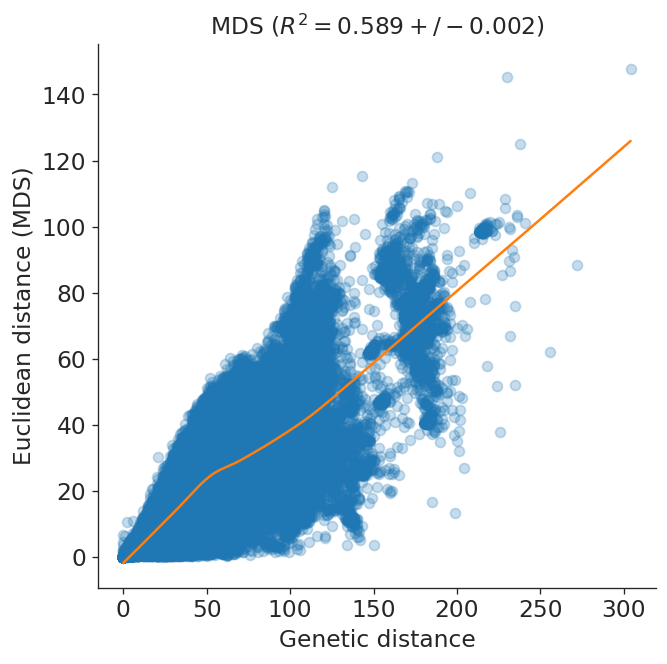

In [115]:
total_df_MDS = pd.read_csv(scatterplot_mds,index_col=0)
metadata_MDS = pd.read_csv(scatterplot_mds_metadata, index_col=0)

mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title(f"MDS ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

## t-SNE

In [116]:
TSNE_df = pd.read_csv(tsne_df, index_col=0)

In [117]:
TSNE_df.head()

,tsne_x,tsne_y,t-sne_label,t-sne_label_default
strain,,,,
FrenchPolynesia2014_060114_016,0.297084,14.552540,6,6
1_0049_PF,-0.690739,12.815197,6,6
1_0030_PF,-1.356451,15.283027,6,6
1_0035_PF,-1.619766,15.105107,6,6
1_0087_PF,-1.405003,15.047993,6,6


In [118]:
merged_tsne_df = TSNE_df.merge(
    node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]],
    on="strain"
)

In [119]:
merged_tsne_df.head()

,strain,tsne_x,tsne_y,t-sne_label,t-sne_label_default,date,y,clade_membership,clade_membership_color
0,FrenchPolynesia2014_060114_016,0.297084,14.552540,6,6,2014.02,155,c1,c1
1,1_0049_PF,-0.690739,12.815197,6,6,2014.00,159,c1,c1
2,1_0030_PF,-1.356451,15.283027,6,6,2013.84,128,c1,c1
3,1_0035_PF,-1.619766,15.105107,6,6,2014.09,130,c1,c1
4,1_0087_PF,-1.405003,15.047993,6,6,2013.92,131,c1,c1


In [120]:
scatterplot_with_tooltip_interactive(
    merged_tsne_df,
    'tsne_x',
    'tsne_y',
    'tsne_x',
    'tsne_y',
    ['strain', "clade_membership"],
    'clade_membership:N',
    domain,
    range_
)

alt.Chart(...)

In [121]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["strain:N"],
    domain,
    range_
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

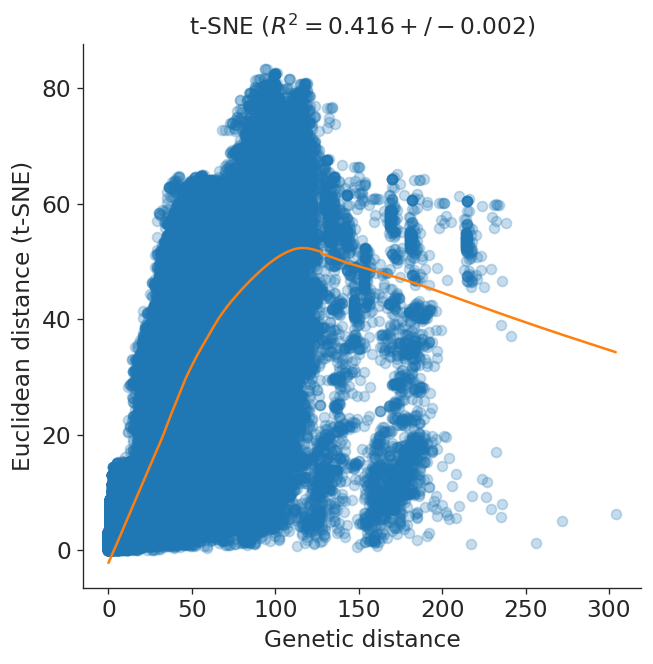

In [122]:
total_df_TSNE = pd.read_csv(scatterplot_tsne,index_col=0)
metadata_TSNE = pd.read_csv(scatterplot_tsne_metadata, index_col=0)

mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")
ax.set_title(f"t-SNE ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

# UMAP

In [123]:
UMAP_df = pd.read_csv(umap_df, index_col=0)

In [124]:
UMAP_df.head()

,umap_x,umap_y,umap_label,umap_label_default
strain,,,,
FrenchPolynesia2014_060114_016,1.983212,8.241117,0,0
1_0049_PF,0.831186,8.539155,0,0
1_0030_PF,1.996316,8.450165,0,0
1_0035_PF,1.944765,8.428259,0,0
1_0087_PF,1.347230,8.495817,0,0


In [125]:
merged_umap_df = UMAP_df.merge(
    node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]],
    on="strain"
)

In [126]:
merged_umap_df.head()

,strain,umap_x,umap_y,umap_label,umap_label_default,date,y,clade_membership,clade_membership_color
0,FrenchPolynesia2014_060114_016,1.983212,8.241117,0,0,2014.02,155,c1,c1
1,1_0049_PF,0.831186,8.539155,0,0,2014.00,159,c1,c1
2,1_0030_PF,1.996316,8.450165,0,0,2013.84,128,c1,c1
3,1_0035_PF,1.944765,8.428259,0,0,2014.09,130,c1,c1
4,1_0087_PF,1.347230,8.495817,0,0,2013.92,131,c1,c1


In [127]:
scatterplot_with_tooltip_interactive(
    merged_umap_df,
    'umap_x',
    'umap_y',
    'umap_x',
    'umap_y',
    ['strain'],
    'clade_membership:N',
    domain,
    range_
)

alt.Chart(...)

In [128]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership:N',
    ["strain:N"],
    domain,
    range_
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap
#chart.save("../docs/UMAPMERSBrush.html")

alt.HConcatChart(...)

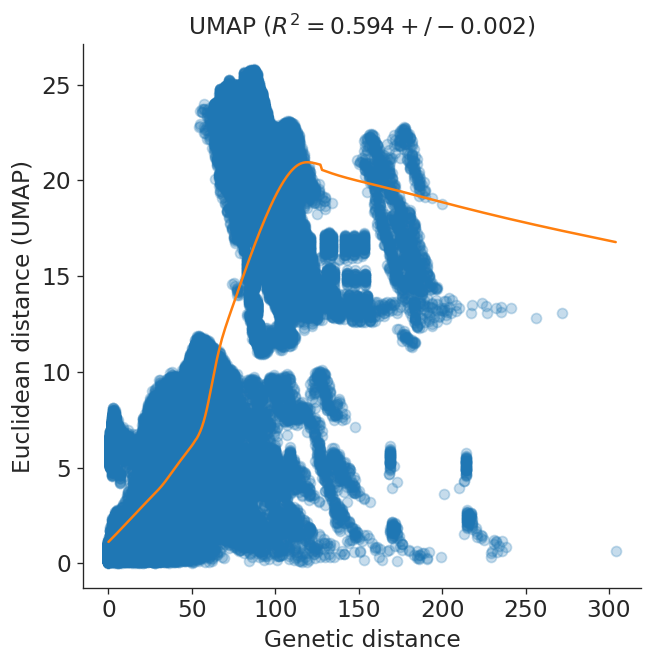

In [129]:
total_df_UMAP = pd.read_csv(scatterplot_umap,index_col=0)
metadata_UMAP = pd.read_csv(scatterplot_umap_metadata, index_col=0)

mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")
ax.set_title(f"UMAP ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

# Linking all plots together clickable with Tree

In [134]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2', 'mds3', 'mds4', 'tsne_x','tsne_y', 'pca1', 'pca2', 'pca3', 'pca4','umap_x','umap_y'],
    ['MDS1', 'MDS2', 'MDS3', 'MDS4', 'TSNE1', 'TSNE2','PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
    'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")", 'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain','clade_membership'],
    domain,
    range_
)

In [135]:
PCA_ = data[4]|data[5]
MDS_ = data[1]|data[2]
PCAMDS = alt.vconcat(PCA_, MDS_)
TSNEUMAP = data[3]|data[6]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart

alt.VConcatChart(...)

In [136]:
save(fullChart, snakemake.output.fullChart)

NameError: name 'snakemake' is not defined

In [ ]:
save(fullChart, snakemake.output.fullChartPNG, scale_factor=2.0)

In [ ]:
from Helpers import get_euclidean_data_frame
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [ ]:
def _get_embedding_columns_by_method(method):
    if method in ("pca"):
        return list(f"{method}1 {method}2 {method}3 {method}4".split())
    if method in ("mds"):
        return list(f"{method}1 {method}2".split())
    if method in ("t-sne"):
        return list("tsne_x tsne_y".split())
    else:
        return list(f"{method}_x {method}_y".split())

In [ ]:
MCC_val = []

for method in ["pca", "mds", "t-sne", "umap"]:
    KDE_df_normal = get_euclidean_data_frame(sampled_df=node_df, column_for_analysis="clade_membership", embedding="method", column_list=_get_embedding_columns_by_method(method))

    KDE_df_cluster =  get_euclidean_data_frame(sampled_df=node_df, column_for_analysis=f"{method}_label", embedding="method", column_list=_get_embedding_columns_by_method(method))

    confusion_matrix_val = confusion_matrix(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    matthews_cc_val = matthews_corrcoef(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    MCC_val.append(matthews_cc_val)

In [ ]:
domain =  sorted(node_df["pca_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
PCA = linking_tree_with_plots_brush(
    node_df,
    ['pca1', 'pca2'],
    ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][1]*100,2)) + ")"],
    'pca_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["mds_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
MDS = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2'],
    ['MDS1', 'MDS2'],
    'mds_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["t-sne_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
TSNE = linking_tree_with_plots_brush(
    node_df,
    ['tsne_x', 'tsne_y'],
    ['TSNE1', 'TSNE2'],
    't-sne_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["umap_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
UMAP = linking_tree_with_plots_brush(
    node_df,
    ['umap_x', 'umap_y'],
    ['UMAP1', 'UMAP2'],
    'umap_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)

In [ ]:
PCAChart = PCA[0]|PCA[1].properties(title= "MCC Value: " + str(round(MCC_val[0],3)))
MDSChart = MDS[0]|MDS[1].properties(title= "MCC Value: " + str(round(MCC_val[1],3)))
TSNEChart = TSNE[0]|TSNE[1].properties(title= "MCC Value: " + str(round(MCC_val[2],3)))
UMAPChart = UMAP[0]|UMAP[1].properties(title= "MCC Value: " + str(round(MCC_val[3],3)))

In [ ]:
PCAMDS = alt.vconcat(PCAChart, MDSChart).resolve_scale(color='independent')
TSNEUMAP = alt.vconcat(TSNEChart, UMAPChart).resolve_scale(color='independent')
fullChart = alt.vconcat(PCAMDS, TSNEUMAP).resolve_scale(color='independent')
fullChart
fullChart.save(snakemake.output.fullChartHDBSCAN)
save(fullChart, snakemake.output.fullChartHDBSCANPNG, scale_factor=2.0)

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.tight_layout(pad=8.0)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.8)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (MDS)")
ax2.set_title(f"MDS ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig(snakemake.output.Scatterplot, dpi=300)

# Supplemental Figures

In [ ]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.MDS_Supplement)
chart.save(snakemake.output.MDS_Supplement_PNG)

In [ ]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]
chart.save(snakemake.output.PCA_Supplement)
chart.save(snakemake.output.PCA_Supplement_PNG)

# HDBSCAN Final Charts

In [ ]:
PCA_df = pd.read_csv(pca_df,index_col=0)
MDS_df = pd.read_csv(mds_df,index_col=0)
TSNE_df = pd.read_csv(tsne_df,index_col=0)
UMAP_df = pd.read_csv(umap_df,index_col=0)
explained_variance_df = pd.read_csv(explained_variance_pca)

In [ ]:
node_df = node_df[["strain", "date", "clade_membership", "y"]].merge(
    PCA_df,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [ ]:
from Helpers import get_euclidean_data_frame
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [ ]:
def _get_embedding_columns_by_method(method):
    if method in ("pca"):
        return list(f"{method}1 {method}2 {method}3 {method}4 {method}5 {method}6 {method}7 {method}8 {method}9 {method}10".split())
    if method in ("mds"):
        return list(f"{method}1 {method}2".split())
    if method in ("t-sne"):
        return list("tsne_x tsne_y".split())
    else:
        return list(f"{method}_x {method}_y".split())

In [ ]:
MCC_val = []

for method in ["pca", "mds", "t-sne", "umap"]:
    KDE_df_normal = get_euclidean_data_frame(sampled_df=node_df, column_for_analysis="clade_membership", embedding="method", column_list=_get_embedding_columns_by_method(method))

    KDE_df_cluster =  get_euclidean_data_frame(sampled_df=node_df, column_for_analysis=f"{method}_label", embedding="method", column_list=_get_embedding_columns_by_method(method))

    confusion_matrix_val = confusion_matrix(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    matthews_cc_val = matthews_corrcoef(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    MCC_val.append(matthews_cc_val)

In [ ]:
domain =  sorted(node_df["pca_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
PCA = linking_tree_with_plots_brush(
    node_df,
    ['pca1', 'pca2'],
    ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][1]*100,2)) + ")"],
    'pca_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["mds_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
MDS = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2'],
    ['MDS1', 'MDS2'],
    'mds_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["t-sne_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
TSNE = linking_tree_with_plots_brush(
    node_df,
    ['tsne_x', 'tsne_y'],
    ['TSNE1', 'TSNE2'],
    't-sne_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)
domain =  sorted(node_df["umap_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
UMAP = linking_tree_with_plots_brush(
    node_df,
    ['umap_x', 'umap_y'],
    ['UMAP1', 'UMAP2'],
    'umap_label:N',
    ['strain','clade_membership'],
    domain,
    range_
)

In [ ]:
PCAChart = PCA[0]|PCA[1].properties(title= "MCC Value: " + str(round(MCC_val[0],3)))
MDSChart = MDS[0]|MDS[1].properties(title= "MCC Value: " + str(round(MCC_val[1],3)))
TSNEChart = TSNE[0]|TSNE[1].properties(title= "MCC Value: " + str(round(MCC_val[2],3)))
UMAPChart = UMAP[0]|UMAP[1].properties(title= "MCC Value: " + str(round(MCC_val[3],3)))

In [ ]:
PCAMDS = alt.vconcat(PCAChart, MDSChart).resolve_scale(color='independent')
TSNEUMAP = alt.vconcat(TSNEChart, UMAPChart).resolve_scale(color='independent')
fullChart = alt.vconcat(PCAMDS, TSNEUMAP).resolve_scale(color='independent')
fullChart
fullChart.save(snakemake.output.fullChartHDBSCAN)
save(fullChart, snakemake.output.fullChartHDBSCANPNG, scale_factor=2.0)